In [ ]:
pip install -U ultralyticsplus==0.0.14


In [ ]:
pip install aiogram


In [ ]:
pip install fastapi


In [ ]:
pip install uvicorn

In [ ]:
!pip install python-telegram-bot==13.13

In [ ]:
111111111111111111111111111111111111111

Ultralytics YOLOv8.0.8 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Fusing layers... 
YOLOv8s summary: 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


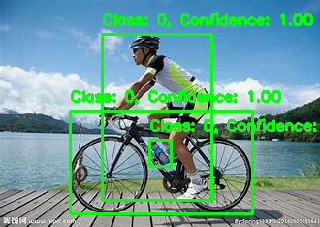

In [ ]:
from telegram.ext import Updater, CommandHandler, MessageHandler, CallbackContext, Filters
from telegram import Update
from io import BytesIO
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from torchvision.transforms import ToPILImage
from PIL import Image
import logging
from telegram import InputFile
from ultralyticsplus import YOLO, render_result

# Enable logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)


# Your YOLO model initialization and configuration code here
model = YOLO('ultralyticsplus/yolov8s')
model.overrides['conf'] = 0.25
model.overrides['iou'] = 0.45
model.overrides['agnostic_nms'] = False
model.overrides['max_det'] = 1000

# Define a function to handle the /start command
def start(update: Update, context: CallbackContext) -> None:
    logging.info('Received /start command')
    update.message.reply_text('Hello! Send me an image, and I will perform object detection on it.')
def handle_image(update: Update, context: CallbackContext) -> None:
    try:
        logging.info('Handling image...')
        if update.message.photo:
          # Get the photo from the message
          photo = update.message.photo[-1].get_file()

          # Download the photo
          photo_bytes = BytesIO()
          photo.download(out=photo_bytes)

          # Convert BytesIO to PIL Image
          pil_image = Image.open(photo_bytes)

          # Perform object detection on the image
          results = model.predict(pil_image)

          # Process the results and draw bounding boxes on the image
          img = cv2.imdecode(np.frombuffer(photo_bytes.getvalue(), np.uint8), -1)

          for detection in results[0].boxes.xyxy:
              if len(detection) >= 6:
                  xmin, ymin, xmax, ymax = detection[:4].int().tolist()
                  confidence = detection[4].item()  # Confidence score
                  class_index = int(detection[5].item())  # Class index
              else:
                  xmin, ymin, xmax, ymax = detection[:4].int().tolist()
                  confidence = 1.0  # Assume a high confidence score since it's not provided
                  class_index = 0  # Assume class index 0 if not provided

              # Draw bounding box
              color = (0, 255, 0)  # Green color
              thickness = 2
              cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)

              # Display class and confidence
              label = f"Class: {class_index}, Confidence: {confidence:.2f}"
              cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

          cv2_imshow(img)
        else:
            update.message.reply_text('Please send an image for object detection.').

        # Convert the modified image back to bytes
        _, img_encoded = cv2.imencode('.jpg', img)
        image_bytes = BytesIO(img_encoded.tobytes())

        # Send the image back as a reply
        update.message.reply_photo(photo=image_bytes)
    except Exception as e:
        logging.error(f'Error handling image: {e}')



# Set up the Updater with a polling interval
updater = Updater("your_token", use_context=True)

# Get the dispatcher to register handlers
dp = updater.dispatcher

# Register command and message handlers
dp.add_handler(CommandHandler("start", start))
dp.add_handler(MessageHandler(Filters.photo, handle_image))  # Handle only messages with photos

# Run the bot until you send a signal to stop
updater.start_polling(poll_interval=0.01)
updater.idle()
